# Practice2： 前馈神经网络

神经网络是由神经元按照一定的连接结构组合而成的网络。神经网络可以看作一个函数，通过简单非线性函数的多次复合，实现输入空间到输出空间的复杂映射 。
前馈神经网络是最早发明的简单人工神经网络。整个网络中的信息单向传播，可以用一个有向无环路图表示，这种网络结构简单，易于实现。

关键知识点如 **图2.1** 所示：

<center><img src="https://ai-studio-static-online.cdn.bcebos.com/0ae8775e92a04173928b4e3fed98b5934f0aad6582dc4143b2205669bfae6b55" width=500></center>
<br><center>图1.1 《神经网络与深度学习》关键知识点回顾</center></br>

本实践主要包含两部分：

* **模型解读**：介绍前馈神经网络的基本概念、网络结构及代码实现，利用前馈神经网络完成一个分类任务，并通过两个简单的实验，观察前馈神经网络的梯度消失问题和死亡ReLU问题，以及对应的优化策略；
* **案例与实践**：基于前馈神经网络完成鸢尾花分类任务。

## 1.1 神经元

神经网络的基本组成单元为带有非线性激活函数的神经元，其结构如如**图1.2**所示。神经元是对生物神经元的结构和特性的一种简化建模，接收一组输入信号并产生输出。

<center><img src="https://ai-studio-static-online.cdn.bcebos.com/d084b5e9e8654367ab4af046184f2f294f85a48417e64e36a79df942d5d6ff68" width="400" hegiht="" ></center>
<center><br>图1.2: 典型的神经元结构</br></center>

### 1.1.1 净活性值

假设一个神经元接收的输入为$\mathbf{x}\in \mathbb{R}^D$，其权重向量为$\mathbf{w}\in \mathbb{R}^D$，神经元所获得的输入信号，即净活性值$z$的计算方法为

$$
z =\mathbf{w}^T\mathbf{x}+b，（1.1）
$$

其中$b$为偏置。

为了提高预测样本的效率，我们通常会将$N$个样本归为一组进行成批地预测。

$$
\boldsymbol{z} =\boldsymbol{X} \boldsymbol{w} + b, (1.2)
$$

其中$\boldsymbol{X}\in \mathbb{R}^{N\times D}$为$N$个样本的特征矩阵，$\boldsymbol{z}\in \mathbb{R}^N$为$N$个预测值组成的列向量。

使用Paddle计算一组输入的净活性值。代码实现如下：

In [1]:
import paddle

# 2个特征数为5的样本
X = paddle.rand(shape=[2, 5])

# 含有5个参数的权重向量
w = paddle.rand(shape=[5, 1])
# 偏置项
b = paddle.rand(shape=[1, 1])

# 使用'paddle.matmul'实现矩阵相乘
z = paddle.matmul(X, w) + b
print("input X:", X)
print("weight w:", w, "\nbias b:", b)
print("output z:", z)

input X: Tensor(shape=[2, 5], dtype=float32, place=Place(cpu), stop_gradient=True,
       [[0.37140140, 0.62776190, 0.19755486, 0.30873957, 0.60557508],
        [0.93816102, 0.51046038, 0.07320242, 0.25924233, 0.36754054]])
weight w: Tensor(shape=[5, 1], dtype=float32, place=Place(cpu), stop_gradient=True,
       [[0.70906043],
        [0.11769784],
        [0.38859957],
        [0.42754999],
        [0.68005097]]) 
bias b: Tensor(shape=[1, 1], dtype=float32, place=Place(cpu), stop_gradient=True,
       [[0.37179747]])
output z: Tensor(shape=[2, 1], dtype=float32, place=Place(cpu), stop_gradient=True,
       [[1.32962298],
        [1.48632216]])


**********

**说明**

在飞桨中，可以使用**nn.Linear**完成输入张量的上述变换。

**********

### 1.1.2 激活函数

净活性值$z$再经过一个非线性函数$f(·)$后，得到神经元的活性值$a$。

$$
a = f(z)，（1.3）
$$

激活函数通常为非线性函数，可以增强神经网络的表示能力和学习能力。常用的激活函数有S型函数和ReLU函数。

#### 1.1.2.1 Sigmoid 型函数

Sigmoid 型函数是指一类S型曲线函数，为两端饱和函数。常用的 Sigmoid 型函数有 Logistic 函数和 Tanh 函数，其数学表达式为


Logistic 函数：

$$
\sigma(z) = \frac{1}{1+\exp(-z)}。（1.4）
$$

Tanh 函数：

$$
\mathrm{tanh}(z) = \frac{\exp(z)-\exp(-z)}{\exp(z)+\exp(-z)}。（1.5）
$$

Logistic函数和Tanh函数的代码实现和可视化如下：

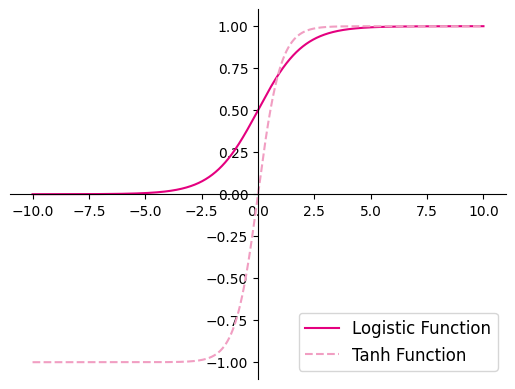

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

# Logistic函数
def logistic(z):
    return 1.0 / (1.0 + paddle.exp(-z))

# Tanh函数
def tanh(z):
    ######
    return (paddle.exp(z)-paddle.exp(-z))/(paddle.exp(z)+paddle.exp(-z))
    ######

# 在[-10,10]的范围内生成10000个输入值，用于绘制函数曲线
z = paddle.linspace(-10, 10, 10000)

plt.figure()
plt.plot(z.tolist(), logistic(z).tolist(), color='#e4007f', label="Logistic Function")
plt.plot(z.tolist(), tanh(z).tolist(), color='#f19ec2', linestyle ='--', label="Tanh Function")

ax = plt.gca() # 获取轴，默认有4个
# 隐藏两个轴，通过把颜色设置成none
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
# 调整坐标轴位置   
ax.spines['left'].set_position(('data',0))
ax.spines['bottom'].set_position(('data',0))
plt.legend(loc='lower right', fontsize='large')

plt.savefig('fw-logistic-tanh.pdf')
plt.show()

**********

**说明**

在飞桨中，可以通过调用`paddle.nn.functional.sigmoid`和`paddle.nn.functional.tanh`实现对张量的Logistic和Tanh计算。

**********

#### 1.1.2.2 ReLU型函数

常见的ReLU函数有ReLU和带泄露的ReLU（Leaky ReLU），数学表达式分别为：

$$
\mathrm{ReLU}(z) = \max(0,z),（1.6）
$$

$$
\mathrm{LeakyReLU}(z) = \max(0,z)+\lambda \min(0,z),（1.7）
$$

其中$\lambda$为超参数。

可视化ReLU和带泄露的ReLU的函数的代码实现和可视化如下：

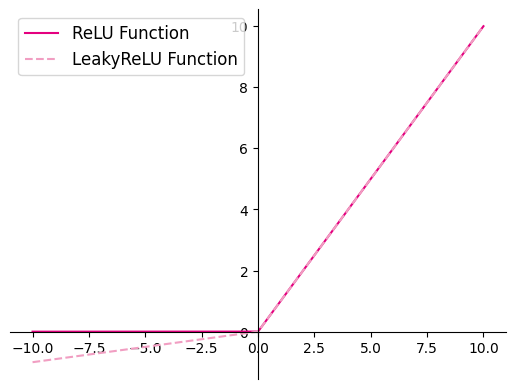

In [4]:
# ReLU
def relu(z):
    return paddle.maximum(z, paddle.to_tensor(0.))

# 带泄露的ReLU
def leaky_relu(z, negative_slope=0.1):
    # 当前版本paddle暂不支持直接将bool类型转成int类型，因此调用了paddle的cast函数来进行显式转换
    a1 = (paddle.cast((z > 0), dtype='float32') * z) 
    a2 = (paddle.cast((z <= 0), dtype='float32') * (negative_slope * z))
    return a1 + a2

# 在[-10,10]的范围内生成一系列的输入值，用于绘制relu、leaky_relu的函数曲线
z = paddle.linspace(-10, 10, 10000)

plt.figure()
plt.plot(z.tolist(), relu(z).tolist(), color="#e4007f", label="ReLU Function")
plt.plot(z.tolist(), leaky_relu(z).tolist(), color="#f19ec2", linestyle="--", label="LeakyReLU Function")

ax = plt.gca()
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['left'].set_position(('data',0))
ax.spines['bottom'].set_position(('data',0))
plt.legend(loc='upper left', fontsize='large')
plt.savefig('fw-relu-leakyrelu.pdf')
plt.show()

**********

**说明**

在飞桨中，可以通过调用`paddle.nn.functional.relu`和`paddle.nn.functional.leaky_relu`完成ReLU与带泄露的ReLU的计算。

**********


## 1.2 基于前馈神经网络的二分类任务

前馈神经网络的网络结构如**图1.3**所示。每一层获取前一层神经元的活性值，并重复上述计算得到该层的活性值，传入到下一层。整个网络中无反馈，信号从输入层向输出层逐层的单向传播，得到网络最后的输出 $\boldsymbol{a}^{(L)}$。

<center><img src="https://ai-studio-static-online.cdn.bcebos.com/dbcf147a4e00446792eb2b93834e0f3154936e08ea124242af8631fde204381c" width="500" hegiht="" ></center>
<center><br>图4.3: 前馈神经网络结构</br></center>

### 1.2.1 数据集构建

这里，我们使用一个二分类数据集：Moon1000数据集，其中训练集640条、验证集160条、测试集200条。
该数据集的数据是从两个带噪音的弯月形状数据分布中采样得到，每个样本包含2个特征。

In [5]:
from nndl.dataset import make_moons

# 采样1000个样本
n_samples = 1000
X, y = make_moons(n_samples=n_samples, shuffle=True, noise=0.5)

# 训练集、验证集和测试集的数量
num_train = 640
num_dev = 160
num_test = 200

X_train, y_train = X[:num_train], y[:num_train]
X_dev, y_dev = X[num_train:num_train + num_dev], y[num_train:num_train + num_dev]
X_test, y_test = X[num_train + num_dev:], y[num_train + num_dev:]

y_train = y_train.reshape([-1,1])
y_dev = y_dev.reshape([-1,1])
y_test = y_test.reshape([-1,1])

outer_circ_x.shape: [500] outer_circ_y.shape: [500]
inner_circ_x.shape: [500] inner_circ_y.shape: [500]
after concat shape: [1000]
X shape: [1000, 2]
y shape: [1000]


### 1.2.2 模型构建

为了更高效的构建前馈神经网络，我们先定义每一层的算子，然后再通过算子组合构建整个前馈神经网络。

假设网络的第$l$层的输入为第$l-1$层的神经元活性值$\boldsymbol{a}^{(l-1)}$，经过一个仿射变换，得到该层神经元的净活性值$\boldsymbol{z}$，再输入到激活函数得到该层神经元的活性值$\boldsymbol{a}$。

在实践中，为了提高模型的处理效率，通常将$N$个样本归为一组进行成批地计算。假设网络第$l$层的输入为$\boldsymbol{A}^{(l-1)}\in \mathbb{R}^{N\times M_{l-1}}$，其中每一行为一个样本，则前馈网络中第$l$层的计算公式为

$$
\mathbf Z^{(l)}=\mathbf A^{(l-1)} \mathbf W^{(l)} +\mathbf b^{(l)}  \in \mathbb{R}^{N\times M_{l}}, (1.8)
$$
$$
\mathbf A^{(l)}=f_l(\mathbf Z^{(l)}) \in \mathbb{R}^{N\times M_{l}}, (1.9)
$$
其中$\mathbf Z^{(l)}$为$N$个样本第$l$层神经元的净活性值，$\mathbf A^{(l)}$为$N$个样本第$l$层神经元的活性值，$\boldsymbol{W}^{(l)}\in \mathbb{R}^{M_{l-1}\times M_{l}}$为第$l$层的权重矩阵，$\boldsymbol{b}^{(l)}\in \mathbb{R}^{1\times M_{l}}$为第$l$层的偏置。

***
为了和代码的实现保存一致性，这里使用形状为$(样本数量\times 特征维度)$的张量来表示一组样本。样本的矩阵$\boldsymbol{X}$是由$N$个$\boldsymbol{x}$的**行向量**组成。而《神经网络与深度学习》中$\boldsymbol{x}$为列向量，因此这里的权重矩阵$\boldsymbol{W}$和偏置$\boldsymbol{b}$和《神经网络与深度学习》中的表示刚好为转置关系。
***



#### 1.2.2.1 线性层算子
公式（1.8）对应一个线性层算子，权重参数采用默认的随机初始化，偏置采用默认的零初始化。代码实现如下：

In [6]:
from nndl.op import Op

# 实现线性层算子
class Linear(Op):
    def __init__(self, input_size, output_size, name, weight_init=paddle.standard_normal, bias_init=paddle.zeros):
        """
        输入：
            - input_size：输入数据维度
            - output_size：输出数据维度
            - name：算子名称
            - weight_init：权重初始化方式，默认使用'paddle.standard_normal'进行标准正态分布初始化
            - bias_init：偏置初始化方式，默认使用全0初始化
        """
        
        self.params = {}
        # 初始化权重
        self.params['W'] = weight_init(shape=[input_size,output_size])
        # 初始化偏置
        self.params['b'] = bias_init(shape=[1,output_size])
        self.inputs = None

        self.name = name

    def forward(self, inputs):
        """
        输入：
            - inputs：shape=[N,input_size], N是样本数量
        输出：
            - outputs：预测值，shape=[N,output_size]
        """
        self.inputs = inputs

        outputs = paddle.matmul(self.inputs, self.params['W']) + self.params['b']
        return outputs

#### 1.2.2.2 Logistic算子

本节采用Logistic函数来作为公式(1.9)中的激活函数。这里也将Logistic函数实现一个算子，代码实现如下：

In [7]:
class Logistic(Op):
    def __init__(self):
        self.inputs = None
        self.outputs = None

    def forward(self, inputs):
        """
        输入：
            - inputs: shape=[N,D]
        输出：
            - outputs：shape=[N,D]
        """
        ######
        # 根据公式（1.4）定义 output， 其中 input 对应公式中的 z。
        outputs = 1.0 / (1.0 + paddle.exp(-inputs))
        ######
        self.outputs = outputs
        return outputs

#### 1.2.2.3 层的串行组合

在定义了神经层的线性层算子和激活函数算子之后，我们可以不断交叉重复使用它们来构建一个多层的神经网络。

下面我们实现一个两层的用于二分类任务的前馈神经网络，选用Logistic作为激活函数，可以利用上面实现的线性层和激活函数算子来组装。代码实现如下：

In [8]:
# 实现一个两层前馈神经网络
class Model_MLP_L2(Op):
    def __init__(self, input_size, hidden_size, output_size):
        """
        输入：
            - input_size：输入维度
            - hidden_size：隐藏层神经元数量
            - output_size：输出维度
        """
        self.fc1 = Linear(input_size, hidden_size, name="fc1")
        self.act_fn1 = Logistic()
        self.fc2 = Linear(hidden_size, output_size, name="fc2")
        self.act_fn2 = Logistic()

    def __call__(self, X):
        return self.forward(X)

    def forward(self, X):
        """
        输入：
            - X：shape=[N,input_size], N是样本数量
        输出：
            - a2：预测值，shape=[N,output_size]
        """
        z1 = self.fc1(X)
        a1 = self.act_fn1(z1)
        z2 = self.fc2(a1)
        a2 = self.act_fn2(z2)
        return a2

**测试一下**

现在，我们实例化一个两层的前馈网络，令其输入层维度为5，隐藏层维度为10，输出层维度为1。
并随机生成一条长度为5的数据输入两层神经网络，观察输出结果。

In [9]:
# 实例化模型
model = Model_MLP_L2(input_size=5, hidden_size=10, output_size=1)
# 随机生成1条长度为5的数据
X = paddle.rand(shape=[1, 5])
result = model(X)
print ("result: ", result)

result:  Tensor(shape=[1, 1], dtype=float32, place=Place(cpu), stop_gradient=True,
       [[0.46585333]])


### 1.2.3 损失函数
二分类交叉熵损失函数见第三章。

### 1.2.4 模型优化
神经网络的参数主要是通过**梯度下降法**进行优化的，因此需要计算最终损失对每个参数的梯度。
线性模型通常比较简单可以直接计算梯度，而神经网络的层数通常比较深，相当于一个复合函数，需要利用链式法则进行反向传播来计算梯度。

#### 1.2.4.1 反向传播算法

前馈神经网络的参数梯度通常使用**误差反向传播**算法来计算。使用误差反向传播算法的前馈神经网络训练过程可以分为以下三步：

1. 前馈计算每一层的净活性值$\boldsymbol{Z}^{(l)}$和激活值$\boldsymbol{A}^ {(l)}$，直到最后一层；
1. 反向传播计算每一层的误差项$\delta^{(l)}=\frac{\partial R}{\partial \boldsymbol{Z}^{(l)}}$；
1. 计算每一层参数的梯度，并更新参数。

在上面实现算子的基础上，来实现误差反向传播算法。在上面的三个步骤中，
1. 第1步是前向计算，可以利用算子的`forward()`方法来实现；
1. 第2步是反向计算梯度，可以利用算子的`backward()`方法来实现；
1. 第3步中的计算参数梯度也放到`backward()`中实现，更新参数放到另外的**优化器**中专门进行。

这样，在模型训练过程中，我们首先执行模型的`forward()`，再执行模型的`backward()`，就得到了所有参数的梯度，之后再利用优化器迭代更新参数。

以这我们这节中构建的两层全连接前馈神经网络`Model_MLP_L2`为例，下图给出了其前向和反向计算过程：

![](https://ai-studio-static-online.cdn.bcebos.com/8562dfb10d464396948d05ee3620cec1d057025dddee43ff92dae3fbb72e8f65)

下面我们按照反向的梯度传播顺序，为每个算子添加`backward()`方法，并在其中实现每一层参数的梯度的计算。

#### 1.2.4.2 损失函数

二分类交叉熵损失函数对神经网络的输出$\hat{\boldsymbol{y}}$的偏导数为:
$$
\frac{\partial R}{\partial \hat{\boldsymbol{y}}} =  -\frac{1}{N}(\mathrm{dialog}(\frac{1}{\hat{\boldsymbol{y}}})\boldsymbol{y}-\mathrm{dialog}(\frac{1}{1-\hat{\boldsymbol{y}}})(1-\boldsymbol{y})) (1.10) \\ 
= -\frac{1}{N}(\frac{1}{\hat{\boldsymbol{y}}}\odot\boldsymbol{y}-\frac{1}{1-\hat{\boldsymbol{y}}}\odot(1-\boldsymbol{y})), (1.11)
$$
其中$dialog(\boldsymbol{x})$表示以向量$\boldsymbol{x}$为对角元素的对角阵，$\frac{1}{\boldsymbol{x}}=\frac{1}{x_1},...,\frac{1}{x_N}$表示逐元素除，$\odot$表示逐元素积。


实现损失函数的`backward()`，代码实现如下：

In [10]:
# 实现交叉熵损失函数
class BinaryCrossEntropyLoss(Op):
    def __init__(self, model):
        self.predicts = None
        self.labels = None
        self.num = None

        self.model = model

    def __call__(self, predicts, labels):
        return self.forward(predicts, labels)

    def forward(self, predicts, labels):
        """
        输入：
            - predicts：预测值，shape=[N, 1]，N为样本数量
            - labels：真实标签，shape=[N, 1]
        输出：
            - 损失值：shape=[1]
        """
        self.predicts = predicts # 预测值 y_hat
        self.labels = labels # 真实标签 y
        self.num = self.predicts.shape[0] # 样本总数
        loss = -1. / self.num * (paddle.matmul(self.labels.t(), paddle.log(self.predicts)) 
                + paddle.matmul((1-self.labels.t()), paddle.log(1-self.predicts)))

        loss = paddle.squeeze(loss, axis=1)
        return loss

    def backward(self):
        ######
        # 根据公式（1.11）计算损失函数对模型预测的导数
        loss_grad_predicts = -1. / self.num * (
        paddle.divide(1., self.predicts) * self.labels - paddle.divide(1., 1. - self.predicts) * (1 - self.labels)
    )
        ######
        # 梯度反向传播
        self.model.backward(loss_grad_predicts)

#### 1.2.4.3 Logistic算子
在本节中，我们使用Logistic激活函数，所以这里为Logistic算子增加的反向函数。

Logistic算子的前向过程表示为$\boldsymbol{A}=\sigma(\boldsymbol{Z})$，其中$\sigma$为Logistic函数，$\boldsymbol{Z} \in R^{N \times D}$和$\boldsymbol{A} \in R^{N \times D}$的每一行表示一个样本。

为了简便起见，我们分别用向量$\boldsymbol{a} \in R^D$ 和 $\boldsymbol{z} \in R^D$表示同一个样本在激活函数前后的表示，则$\boldsymbol{a}$对$\boldsymbol{z}$的偏导数为：
$$
\frac{\partial \boldsymbol{a}}{\partial \boldsymbol{z}}=diag(\boldsymbol{a}\odot(1-\boldsymbol{a}))\in R^{D \times D}, (1.12)
$$
按照反向传播算法，令$\delta_{\boldsymbol{a}}=\frac{\partial R}{\partial \boldsymbol{a}} \in R^D$表示最终损失$R$对Logistic算子的单个输出$\boldsymbol{a}$的梯度，则
$$
\delta_{\boldsymbol{z}} \triangleq \frac{\partial R}{\partial \boldsymbol{z}} = \frac{\partial \boldsymbol{a}}{\partial \boldsymbol{z}}\delta_{\boldsymbol{a}}  (1.13) \\
= diag(\boldsymbol{a}\odot(1-\boldsymbol{a}))\delta_{\boldsymbol(a)}, (1.14) \\
= \boldsymbol{a}\odot(1-\boldsymbol{a})\odot\delta_{\boldsymbol(a)}。 (1.15)
$$

将上面公式利用批量数据表示的方式重写，令$\delta_{\boldsymbol{A}} =\frac{\partial R}{\partial \boldsymbol{A}} \in R^{N \times D}$表示最终损失$R$对Logistic算子输出$A$的梯度，损失函数对Logistic函数输入$\boldsymbol{Z}$的导数为
$$
\delta_{\boldsymbol{Z}}=\boldsymbol{A} \odot (1-\boldsymbol{A})\odot \delta_{\boldsymbol{A}} \in R^{N \times D},(1.16)
$$
$\delta_{\boldsymbol{Z}}$为Logistic算子反向传播的输出。

由于Logistic函数中没有参数，这里不需要在`backward()`方法中计算该算子参数的梯度。

In [11]:
class Logistic(Op):
    def __init__(self):
        self.inputs = None
        self.outputs = None
        self.params = None

    def forward(self, inputs):
        outputs = 1.0 / (1.0 + paddle.exp(-inputs))
        self.outputs = outputs
        return outputs

    def backward(self, grads):
        # 计算Logistic激活函数对输入的导数
        outputs_grad_inputs = paddle.multiply(self.outputs, (1.0 - self.outputs))
        return paddle.multiply(grads,outputs_grad_inputs)

#### 1.2.4.4 线性层

线性层算子Linear的前向过程表示为$\boldsymbol{Y}=\boldsymbol{X}\boldsymbol{W}+\boldsymbol{b}$，其中输入为$\boldsymbol{X} \in R^{N \times M}$，输出为$\boldsymbol{Y} \in R^{N \times D}$，参数为权重矩阵$\boldsymbol{W} \in R^{M \times D}$和偏置$\boldsymbol{b} \in R^{1 \times D}$。$\boldsymbol{X}$和$\boldsymbol{Y}$中的每一行表示一个样本。

为了简便起见，我们用向量$\boldsymbol{x}\in R^M$和$\boldsymbol{y}\in R^D$表示同一个样本在线性层算子中的输入和输出，则有$\boldsymbol{y}=\boldsymbol{W}^T\boldsymbol{x}+\boldsymbol{b}^T$。$\boldsymbol{y}$对输入$\boldsymbol{x}$的偏导数为
$$
\frac{\partial \boldsymbol{y}}{\partial \boldsymbol{x}} = \boldsymbol{W}\in R^{D \times M}。(1.17)
$$

**线性层输入的梯度** 按照反向传播算法，令$\delta_{\boldsymbol{y}}=\frac{\partial R}{\partial \boldsymbol{y}}\in R^D$表示最终损失$R$对线性层算子的单个输出$\boldsymbol{y}$的梯度，则
$$
\delta_{\boldsymbol{x}} \triangleq \frac{\partial R}{\partial \boldsymbol{x}}= \boldsymbol{W} \delta_{\boldsymbol{y}}。(1.18)
$$

将上面公式利用批量数据表示的方式重写，令$\delta_{\boldsymbol{Y}}=\frac{\partial R}{\partial \boldsymbol{Y}}\in \mathbb{R}^{N\times D}$表示最终损失$R$对线性层算子输出$\boldsymbol{Y}$的梯度，公式可以重写为
$$
\delta_{\boldsymbol{X}} =\delta_{\boldsymbol{Y}} \boldsymbol{W}^T,(1.19)
$$
其中$\delta_{\boldsymbol{X}}$为线性层算子反向函数的输出。




**计算线性层参数的梯度** 由于线性层算子中包含有可学习的参数$\boldsymbol{W}$和$\boldsymbol{b}$，因此`backward()`除了实现梯度反传外，还需要计算算子内部的参数的梯度。

令$\delta_{\boldsymbol{y}}=\frac{\partial R}{\partial \boldsymbol{y}}\in \mathbb{R}^D$表示最终损失$R$对线性层算子的单个输出$\boldsymbol{y}$的梯度，则
$$
\delta_{\boldsymbol{W}} \triangleq \frac{\partial R}{\partial \boldsymbol{W}} = \boldsymbol{x}\delta_{\boldsymbol{y}}^T,(1.20) \\
\delta_{\boldsymbol{b}} \triangleq \frac{\partial R}{\partial \boldsymbol{b}} = \delta_{\boldsymbol{y}}^T。(1.21)
$$

将上面公式利用批量数据表示的方式重写，令$\delta_{\boldsymbol{Y}}=\frac{\partial R}{\partial \boldsymbol{Y}}\in \mathbb{R}^{N\times D}$表示最终损失$R$对线性层算子输出$\boldsymbol{Y}$的梯度，则公式可以重写为
$$
\delta_{\boldsymbol{W}} = \boldsymbol{X}^T \delta_{\boldsymbol{Y}},(1.22) \\
\delta_{\boldsymbol{b}} = \mathbf{1}^T \delta_{\boldsymbol{Y}}。(1.23)
$$

具体实现代码如下：

In [12]:
class Linear(Op):
    def __init__(self, input_size, output_size, name, weight_init=paddle.standard_normal, bias_init=paddle.zeros):
        self.params = {}
        self.params['W'] = weight_init(shape=[input_size, output_size])
        self.params['b'] = bias_init(shape=[1, output_size])

        self.inputs = None
        self.grads = {}

        self.name = name

    def forward(self, inputs):
        self.inputs = inputs
        outputs = paddle.matmul(self.inputs, self.params['W']) + self.params['b']
        return outputs

    def backward(self, grads):
        """
        输入：
            - grads：损失函数对当前层输出的导数
        输出：
            - 损失函数对当前层输入的导数
        """
        self.grads['W'] = paddle.matmul(self.inputs.T, grads)
        self.grads['b'] = paddle.sum(grads, axis=0)

        # 线性层输入的梯度
        return paddle.matmul(grads, self.params['W'].T)

#### 1.2.4.5 整个网络

实现完整的两层神经网络的前向和反向计算。代码实现如下：

In [14]:
class Model_MLP_L2(Op):
    def __init__(self, input_size, hidden_size, output_size):
        # 线性层
        self.fc1 = Linear(input_size, hidden_size, name="fc1")
        # Logistic激活函数层
        self.act_fn1 = Logistic()
        self.fc2 = Linear(hidden_size, output_size, name="fc2")
        self.act_fn2 = Logistic()

        self.layers = [self.fc1, self.act_fn1, self.fc2, self.act_fn2]

    def __call__(self, X):
        return self.forward(X)

    # 前向计算
    def forward(self, X):
        z1 = self.fc1(X)
        a1 = self.act_fn1(z1)
        z2 = self.fc2(a1)
        a2 = self.act_fn2(z2)
        return a2
        
    # 反向计算
    def backward(self, loss_grad_a2):
        loss_grad_z2 = self.act_fn2.backward(loss_grad_a2)
        loss_grad_a1 = self.fc2.backward(loss_grad_z2)
        loss_grad_z1 = self.act_fn1.backward(loss_grad_a1)
        loss_grad_inputs = self.fc1.backward(loss_grad_z1)

## 1.3 自动梯度计算和预定义算子

虽然我们能够通过模块化的方式比较好地对神经网络进行组装，但是每个模块的梯度计算过程仍然十分繁琐且容易出错。在深度学习框架中，已经封装了自动梯度计算的功能，我们只需要聚焦模型架构，不再需要耗费精力进行计算梯度。

飞桨提供了`paddle.nn.Layer`类，来方便快速的实现自己的层和模型。模型和层都可以基于`paddle.nn.Layer`扩充实现，模型只是一种特殊的层。

继承了`paddle.nn.Layer`类的算子中，可以在内部直接调用其它继承`paddle.nn.Layer`类的算子，飞桨框架会自动识别算子中内嵌的`paddle.nn.Layer`类算子，并自动计算它们的梯度，并在优化时更新它们的参数。

### 1.3.1 利用预定义算子重新实现前馈神经网络
下面我们使用Paddle的预定义算子来重新实现二分类任务。
主要使用到的预定义算子为`paddle.nn.Linear`：

`class paddle.nn.Linear(in_features, out_features, weight_attr=None, bias_attr=None, name=None)`

`paddle.nn.Linear`算子可以接受一个形状为[batch_size,∗,in_features]的**输入张量**，其中"∗"表示张量中可以有任意的其它额外维度，并计算它与形状为[in_features, out_features]的**权重矩阵**的乘积，然后生成形状为[batch_size,∗,out_features]的**输出张量**。 `paddle.nn.Linear`算子默认有偏置参数，可以通过`bias_attr=False`设置不带偏置。

***
paddle.nn 目录下包含飞桨框架支持的神经网络层和相关函数的相关API。paddle.nn.functional下都是一些函数实现。
***


代码实现如下：

In [15]:
import paddle.nn as nn
import paddle.nn.functional as F
from paddle.nn.initializer import Constant, Normal, Uniform

class Model_MLP_L2_V2(paddle.nn.Layer):
    def __init__(self, input_size, hidden_size, output_size):
        super(Model_MLP_L2_V2, self).__init__()
        # 使用'paddle.nn.Linear'定义线性层。
        # 其中第一个参数（in_features）为线性层输入维度；第二个参数（out_features）为线性层输出维度
        # weight_attr为权重参数属性，这里使用'paddle.nn.initializer.Normal'进行随机高斯分布初始化
        # bias_attr为偏置参数属性，这里使用'paddle.nn.initializer.Constant'进行常量初始化
        self.fc1 = nn.Linear(input_size, hidden_size,
                                weight_attr=paddle.ParamAttr(initializer=Normal(mean=0., std=1.)),
                                bias_attr=paddle.ParamAttr(initializer=Constant(value=0.0)))
        self.fc2 = nn.Linear(hidden_size, output_size,
                                weight_attr=paddle.ParamAttr(initializer=Normal(mean=0., std=1.)),
                                bias_attr=paddle.ParamAttr(initializer=Constant(value=0.0)))
        # 使用'paddle.nn.functional.sigmoid'定义 Logistic 激活函数
        self.act_fn = F.sigmoid
        
    # 前向计算
    def forward(self, inputs):
        z1 = self.fc1(inputs)
        a1 = self.act_fn(z1)
        z2 = self.fc2(a1)
        a2 = self.act_fn(z2)
        return a2

### 1.3.2 完善Runner类

实现网络模型在训练过程中使用自动梯度计算；模型保存时，使用`state_dict`方法获取模型参数；模型加载时，使用`set_state_dict`方法加载模型参数.

In [16]:
class RunnerV2_2(object):
    def __init__(self, model, optimizer, metric, loss_fn, **kwargs):
        self.model = model
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.metric = metric

        # 记录训练过程中的评估指标变化情况
        self.train_scores = []
        self.dev_scores = []

        # 记录训练过程中的评价指标变化情况
        self.train_loss = []
        self.dev_loss = []

    def train(self, train_set, dev_set, **kwargs):
        # 将模型切换为训练模式
        self.model.train()

        # 传入训练轮数，如果没有传入值则默认为0
        num_epochs = kwargs.get("num_epochs", 0)
        # 传入log打印频率，如果没有传入值则默认为100
        log_epochs = kwargs.get("log_epochs", 100)
        # 传入模型保存路径，如果没有传入值则默认为"best_model.pdparams"
        save_path = kwargs.get("save_path", "best_model.pdparams")

        # log打印函数，如果没有传入则默认为"None"
        custom_print_log = kwargs.get("custom_print_log", None) 
        
        # 记录全局最优指标
        best_score = 0
        # 进行num_epochs轮训练
        for epoch in range(num_epochs):
            X, y = train_set
            # 获取模型预测
            logits = self.model(X)
            # 计算交叉熵损失
            trn_loss = self.loss_fn(logits, y)
            self.train_loss.append(trn_loss.item())
            # 计算评估指标
            trn_score = self.metric(logits, y).item()
            self.train_scores.append(trn_score)

            # 自动计算参数梯度
            trn_loss.backward()
            if custom_print_log is not None:
                # 打印每一层的梯度
                custom_print_log(self)

            # 参数更新
            self.optimizer.step()
            # 清空梯度
            self.optimizer.clear_grad()

            dev_score, dev_loss = self.evaluate(dev_set)
            # 如果当前指标为最优指标，保存该模型
            if dev_score > best_score:
                self.save_model(save_path)
                print(f"[Evaluate] best accuracy performence has been updated: {best_score:.5f} --> {dev_score:.5f}")
                best_score = dev_score

            if log_epochs and epoch % log_epochs == 0:
                print(f"[Train] epoch: {epoch}/{num_epochs}, loss: {trn_loss.item()}")
                
    # 模型评估阶段，使用'paddle.no_grad()'控制不计算和存储梯度
    @paddle.no_grad()
    def evaluate(self, data_set):
        # 将模型切换为评估模式
        self.model.eval()

        X, y = data_set
        # 计算模型输出
        logits = self.model(X)
        # 计算损失函数
        loss = self.loss_fn(logits, y).item()
        self.dev_loss.append(loss)
        # 计算评估指标
        score = self.metric(logits, y).item()
        self.dev_scores.append(score)
        return score, loss
    
    # 模型测试阶段，使用'paddle.no_grad()'控制不计算和存储梯度
    @paddle.no_grad()
    def predict(self, X):
        # 将模型切换为评估模式
        self.model.eval()
        return self.model(X)

    # 使用'model.state_dict()'获取模型参数，并进行保存
    def save_model(self, saved_path):
        paddle.save(self.model.state_dict(), saved_path)

    # 使用'model.set_state_dict'加载模型参数
    def load_model(self, model_path):
        state_dict = paddle.load(model_path)
        self.model.set_state_dict(state_dict)

### 1.3.3 模型训练

实例化RunnerV2类，并传入训练配置，代码实现如下：

In [17]:
from nndl.metric import accuracy
# 设置模型
input_size = 2
hidden_size = 5
output_size = 1
model = Model_MLP_L2_V2(input_size=input_size, hidden_size=hidden_size, output_size=output_size)

# 设置损失函数
loss_fn = F.binary_cross_entropy

# 设置优化器
learning_rate = 0.2
optimizer = paddle.optimizer.SGD(learning_rate=learning_rate, parameters=model.parameters())

# 设置评价指标
metric = accuracy

# 其他参数
epoch_num = 1000
saved_path = 'best_model.pdparams'

# 实例化RunnerV2类，并传入训练配置
runner = RunnerV2_2(model, optimizer, metric, loss_fn)

runner.train([X_train, y_train], [X_dev, y_dev], num_epochs=epoch_num, log_epochs=50, save_path="best_model.pdparams")

[Evaluate] best accuracy performence has been updated: 0.00000 --> 0.66875
[Train] epoch: 0/1000, loss: 0.6625241041183472
[Evaluate] best accuracy performence has been updated: 0.66875 --> 0.67500
[Evaluate] best accuracy performence has been updated: 0.67500 --> 0.70625
[Evaluate] best accuracy performence has been updated: 0.70625 --> 0.71250
[Evaluate] best accuracy performence has been updated: 0.71250 --> 0.71875
[Evaluate] best accuracy performence has been updated: 0.71875 --> 0.72500
[Evaluate] best accuracy performence has been updated: 0.72500 --> 0.73125
[Evaluate] best accuracy performence has been updated: 0.73125 --> 0.73750
[Evaluate] best accuracy performence has been updated: 0.73750 --> 0.74375
[Evaluate] best accuracy performence has been updated: 0.74375 --> 0.75625
[Evaluate] best accuracy performence has been updated: 0.75625 --> 0.76250
[Evaluate] best accuracy performence has been updated: 0.76250 --> 0.76875
[Evaluate] best accuracy performence has been update

将训练过程中训练集与验证集的准确率变化情况进行可视化。

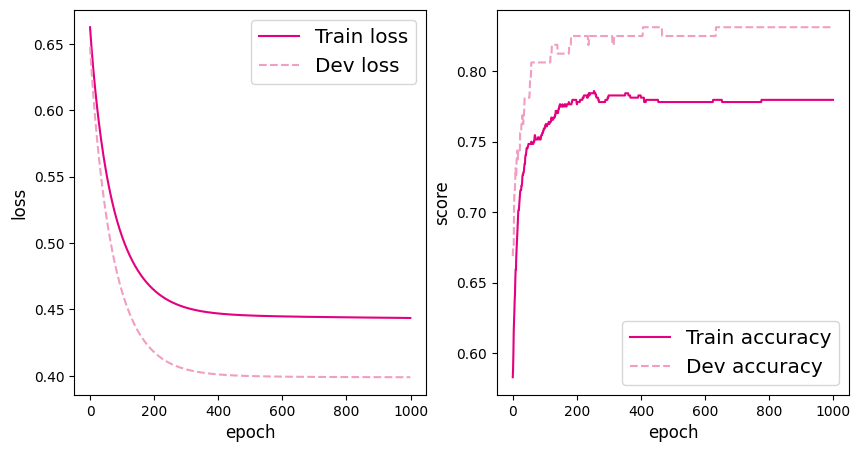

In [18]:
# 可视化观察训练集与验证集的指标变化情况
def plot(runner, fig_name):
    plt.figure(figsize=(10,5))
    epochs = [i for i in range(len(runner.train_scores))]

    plt.subplot(1,2,1)
    plt.plot(epochs, runner.train_loss, color='#e4007f', label="Train loss")
    plt.plot(epochs, runner.dev_loss, color='#f19ec2', linestyle='--', label="Dev loss")
    # 绘制坐标轴和图例
    plt.ylabel("loss", fontsize='large')
    plt.xlabel("epoch", fontsize='large')
    plt.legend(loc='upper right', fontsize='x-large')

    plt.subplot(1,2,2)
    plt.plot(epochs, runner.train_scores, color='#e4007f', label="Train accuracy")
    plt.plot(epochs, runner.dev_scores, color='#f19ec2', linestyle='--', label="Dev accuracy")
    # 绘制坐标轴和图例
    plt.ylabel("score", fontsize='large')
    plt.xlabel("epoch", fontsize='large')
    plt.legend(loc='lower right', fontsize='x-large')
    
    plt.savefig(fig_name)
    plt.show()

plot(runner, 'fw-acc.pdf')

### 1.3.4 性能评价

使用测试数据对训练完成后的最优模型进行评价，观察模型在测试集上的准确率以及loss情况。代码如下：

In [19]:
# 模型评价
runner.load_model("best_model.pdparams")
score, loss = runner.evaluate([X_test, y_test])
print("[Test] score/loss: {:.4f}/{:.4f}".format(score, loss))

[Test] score/loss: 0.8050/0.4193


从结果来看，模型在测试集上取得了较高的准确率。

## 1.4 优化问题（选择性学习）

在本节中，我们通过实践来发现神经网络模型的优化问题，并思考如何改进。

### 1.4.1 参数初始化

实现一个神经网络前，需要先初始化模型参数。如果对每一层的权重和偏置都用0初始化，那么通过第一遍前向计算，所有隐藏层神经元的激活值都相同；在反向传播时，所有权重的更新也都相同，这样会导致隐藏层神经元没有差异性，出现**对称权重现象**。

接下来，将模型参数全都初始化为0，看实验结果。这里重新定义了一个类`TwoLayerNet_Zeros`，两个线性层的参数全都初始化为0。

In [20]:
import paddle.nn as nn
import paddle.nn.functional as F
from paddle.nn.initializer import Constant, Normal, Uniform

class Model_MLP_L2_V4(paddle.nn.Layer):
    def __init__(self, input_size, hidden_size, output_size):
        super(Model_MLP_L2_V4, self).__init__()
        # 使用'paddle.nn.Linear'定义线性层。
        # 其中in_features为线性层输入维度；out_features为线性层输出维度
        # weight_attr为权重参数属性
        # bias_attr为偏置参数属性
        self.fc1 = nn.Linear(input_size, hidden_size,
                                weight_attr=paddle.ParamAttr(initializer=Constant(value=0.0)),
                                bias_attr=paddle.ParamAttr(initializer=Constant(value=0.0)))
        self.fc2 = nn.Linear(hidden_size, output_size,
                                weight_attr=paddle.ParamAttr(initializer=Constant(value=0.0)),
                                bias_attr=paddle.ParamAttr(initializer=Constant(value=0.0)))
        # 使用'paddle.nn.functional.sigmoid'定义 Logistic 激活函数
        self.act_fn = F.sigmoid
        
    # 前向计算
    def forward(self, inputs):
        z1 = self.fc1(inputs)
        a1 = self.act_fn(z1)
        z2 = self.fc2(a1)
        a2 = self.act_fn(z2)
        return a2

In [21]:
def print_weights(runner):
    print('The weights of the Layers：')
    
    for item in runner.model.sublayers():
        print(item.full_name())
        for param in item.parameters():
            print(param.numpy())
        

利用Runner类训练模型：

In [22]:
# 设置模型
input_size = 2
hidden_size = 5
output_size = 1
model = Model_MLP_L2_V4(input_size=input_size, hidden_size=hidden_size, output_size=output_size)

# 设置损失函数
loss_fn = F.binary_cross_entropy

# 设置优化器
learning_rate = 0.2 #5e-2
optimizer = paddle.optimizer.SGD(learning_rate=learning_rate, parameters=model.parameters())

# 设置评价指标
metric = accuracy

# 其他参数
epoch = 2000
saved_path = 'best_model.pdparams'

# 实例化RunnerV2类，并传入训练配置
runner = RunnerV2_2(model, optimizer, metric, loss_fn)

runner.train([X_train, y_train], [X_dev, y_dev], num_epochs=5, log_epochs=50, save_path="best_model.pdparams",custom_print_log=print_weights)

The weights of the Layers：
linear_2
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
[0. 0. 0. 0. 0.]
linear_3
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[0.]
[Evaluate] best accuracy performence has been updated: 0.00000 --> 0.49375
[Train] epoch: 0/5, loss: 0.693146824836731
The weights of the Layers：
linear_2
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
[0. 0. 0. 0. 0.]
linear_3
[[-0.0015625]
 [-0.0015625]
 [-0.0015625]
 [-0.0015625]
 [-0.0015625]]
[-0.003125]
The weights of the Layers：
linear_2
[[-1.8374551e-05 -1.8374551e-05 -1.8374551e-05 -1.8374551e-05
  -1.8374551e-05]
 [ 1.4767989e-05  1.4767989e-05  1.4767989e-05  1.4767989e-05
   1.4767989e-05]]
[1.08337e-06 1.08337e-06 1.08337e-06 1.08337e-06 1.08337e-06]
linear_3
[[-0.00294922]
 [-0.00294922]
 [-0.00294922]
 [-0.00294922]
 [-0.00294922]]
[-0.00589845]
The weights of the Layers：
linear_2
[[-5.3168547e-05 -5.3168547e-05 -5.3168547e-05 -5.3168547e-05
  -5.3168547e-05]
 [ 4.2583335e-05  4.2583335e-05  4.2583335e-05  4.2583335e-05
   4.2583335e-05]]
[2.898172

可视化训练和验证集上的主准确率和loss变化：

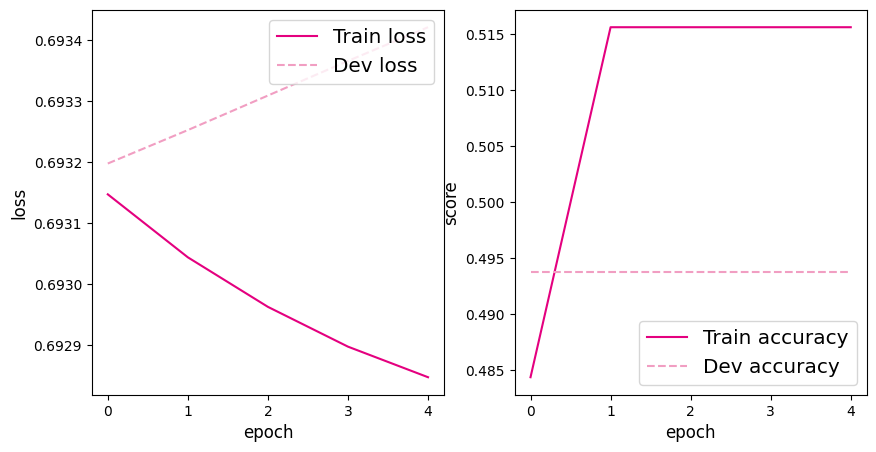

In [23]:
plot(runner, "fw-zero.pdf")

从输出结果看，二分类准确率为50%左右，说明模型没有学到任何内容。训练和验证loss几乎没有怎么下降。

为了避免对称权重现象，可以使用高斯分布或均匀分布初始化神经网络的参数。

高斯分布和均匀分布采样的实现和可视化代码如下：

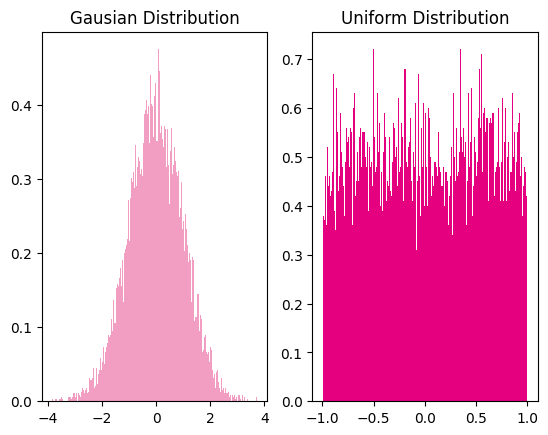

In [24]:
# 使用'paddle.normal'实现高斯分布采样，其中'mean'为高斯分布的均值，'std'为高斯分布的标准差，'shape'为输出形状
gausian_weights = paddle.normal(mean=0.0, std=1.0, shape=[10000])
# 使用'paddle.uniform'实现在[min,max)范围内的均匀分布采样，其中'shape'为输出形状
uniform_weights = paddle.uniform(shape=[10000], min=- 1.0, max=1.0)

# 绘制两种参数分布
plt.figure()
plt.subplot(1,2,1)
plt.title('Gausian Distribution')
plt.hist(gausian_weights.numpy(), bins=200, density=True, color='#f19ec2')
plt.subplot(1,2,2)
plt.title('Uniform Distribution')
plt.hist(uniform_weights.numpy(), bins=200, density=True, color='#e4007f')
plt.savefig('fw-gausian-uniform.pdf')
plt.show()

### 1.4.2 梯度消失问题

在神经网络的构建过程中，随着网络层数的增加，理论上网络的拟合能力也应该是越来越好的。但是随着网络变深，参数学习更加困难，容易出现梯度消失问题。

由于Sigmoid型函数的饱和性，饱和区的导数更接近于0，误差经过每一层传递都会不断衰减。当网络层数很深时，梯度就会不停衰减，甚至消失，使得整个网络很难训练，这就是所谓的梯度消失问题。
在深度神经网络中，减轻梯度消失问题的方法有很多种，一种简单有效的方式就是使用导数比较大的激活函数，如：ReLU。

下面通过一个简单的实验观察前馈神经网络的梯度消失现象和改进方法。

#### 1.4.2.1 模型构建

定义一个前馈神经网络，包含4个隐藏层和1个输出层，通过传入的参数指定激活函数。代码实现如下：

In [25]:
# 定义多层前馈神经网络
class Model_MLP_L5(paddle.nn.Layer):
    def __init__(self, input_size, output_size, act='sigmoid', w_init=Normal(mean=0.0, std=0.01), b_init=Constant(value=1.0)):
        super(Model_MLP_L5, self).__init__()
        self.fc1 = paddle.nn.Linear(input_size, 3)
        self.fc2 = paddle.nn.Linear(3, 3)
        self.fc3 = paddle.nn.Linear(3, 3)
        self.fc4 = paddle.nn.Linear(3, 3)
        self.fc5 = paddle.nn.Linear(3, output_size)
        # 定义网络使用的激活函数
        if act == 'sigmoid':
            self.act = F.sigmoid
        elif act == 'relu':
            self.act = F.relu
        elif act == 'lrelu':
            self.act = F.leaky_relu
        else:
            raise ValueError("Please enter sigmoid relu or lrelu!")
        # 初始化线性层权重和偏置参数
        self.init_weights(w_init, b_init)

    # 初始化线性层权重和偏置参数
    def init_weights(self, w_init, b_init):
        # 使用'named_sublayers'遍历所有网络层
        for n, m in self.named_sublayers():
            # 如果是线性层，则使用指定方式进行参数初始化
            if isinstance(m, nn.Linear):
                w_init(m.weight)
                b_init(m.bias)

    def forward(self, inputs):
        outputs = self.fc1(inputs)
        outputs = self.act(outputs)
        outputs = self.fc2(outputs)
        outputs = self.act(outputs)
        outputs = self.fc3(outputs)
        outputs = self.act(outputs)
        outputs = self.fc4(outputs)
        outputs = self.act(outputs)
        outputs = self.fc5(outputs)
        outputs = F.sigmoid(outputs)
        return outputs

#### 1.4.2.2 使用Sigmoid型函数进行训练

使用Sigmoid型函数作为激活函数，为了便于观察梯度消失现象，只进行一轮网络优化。代码实现如下：

定义梯度打印函数

In [26]:
def print_grads(runner):
    # 打印每一层的权重的模
    print('The gradient of the Layers：')
    for item in runner.model.sublayers():
        if len(item.parameters())==2:
            print(item.full_name(), paddle.norm(item.parameters()[0].grad, p=2.).numpy()[0])

In [27]:
paddle.seed(102)
# 学习率大小
lr = 0.01

# 定义网络，激活函数使用sigmoid
model =  Model_MLP_L5(input_size=2, output_size=1, act='sigmoid')

# 定义优化器
optimizer = paddle.optimizer.SGD(learning_rate=lr, parameters=model.parameters())

# 定义损失函数，使用交叉熵损失函数
loss_fn = F.binary_cross_entropy

# 定义评价指标
metric = accuracy

# 指定梯度打印函数
custom_print_log=print_grads

实例化RunnerV2_2类，并传入训练配置。代码实现如下：

In [28]:
# 实例化Runner类
runner = RunnerV2_2(model, optimizer, metric, loss_fn)

模型训练，打印网络每层梯度值的$\ell_2$范数。代码实现如下：

In [29]:
# 启动训练
runner.train([X_train, y_train], [X_dev, y_dev], 
            num_epochs=1, log_epochs=None, 
            save_path="best_model.pdparams", 
            custom_print_log=custom_print_log)

The gradient of the Layers：
linear_4 6.7438055e-11
linear_5 1.8051015e-08
linear_6 5.259917e-06
linear_7 0.0016461131
linear_8 0.3189895
[Evaluate] best accuracy performence has been updated: 0.00000 --> 0.50625


I1226 16:15:00.902618   575 eager_method.cc:140] Warning:: 0D Tensor cannot be used as 'Tensor.numpy()[0]' . In order to avoid this problem, 0D Tensor will be changed to 1D numpy currently, but it's not correct and will be removed in release 2.6. For Tensor contain only one element, Please modify  'Tensor.numpy()[0]' to 'float(Tensor)' as soon as possible, otherwise 'Tensor.numpy()[0]' will raise error in release 2.6.
I1226 16:15:00.903302   575 eager_method.cc:140] Warning:: 0D Tensor cannot be used as 'Tensor.numpy()[0]' . In order to avoid this problem, 0D Tensor will be changed to 1D numpy currently, but it's not correct and will be removed in release 2.6. For Tensor contain only one element, Please modify  'Tensor.numpy()[0]' to 'float(Tensor)' as soon as possible, otherwise 'Tensor.numpy()[0]' will raise error in release 2.6.
I1226 16:15:00.903376   575 eager_method.cc:140] Warning:: 0D Tensor cannot be used as 'Tensor.numpy()[0]' . In order to avoid this problem, 0D Tensor will 

观察实验结果可以发现，梯度经过每一个神经层的传递都会不断衰减，最终传递到第一个神经层时，梯度几乎完全消失。

#### 1.4.2.3 使用ReLU函数进行模型训练

In [30]:
paddle.seed(102)
lr = 0.01  # 学习率大小

# 定义网络，激活函数使用relu
model =  Model_MLP_L5(input_size=2, output_size=1, act='relu')

# 定义优化器
optimizer = paddle.optimizer.SGD(learning_rate=lr, parameters=model.parameters())

# 定义损失函数
# 定义损失函数，这里使用交叉熵损失函数
loss_fn = F.binary_cross_entropy

# 定义评估指标
metric = accuracy

# 实例化Runner
runner = RunnerV2_2(model, optimizer, metric, loss_fn)

# 启动训练
runner.train([X_train, y_train], [X_dev, y_dev], 
            num_epochs=1, log_epochs=None, 
            save_path="best_model.pdparams", 
            custom_print_log=custom_print_log)

The gradient of the Layers：
linear_9 4.5521123e-08
linear_10 3.3180454e-06
linear_11 0.00018949171
linear_12 0.011657994
linear_13 0.4406196
[Evaluate] best accuracy performence has been updated: 0.00000 --> 0.50625


I1226 16:15:04.660789   575 eager_method.cc:140] Warning:: 0D Tensor cannot be used as 'Tensor.numpy()[0]' . In order to avoid this problem, 0D Tensor will be changed to 1D numpy currently, but it's not correct and will be removed in release 2.6. For Tensor contain only one element, Please modify  'Tensor.numpy()[0]' to 'float(Tensor)' as soon as possible, otherwise 'Tensor.numpy()[0]' will raise error in release 2.6.
I1226 16:15:04.660992   575 eager_method.cc:140] Warning:: 0D Tensor cannot be used as 'Tensor.numpy()[0]' . In order to avoid this problem, 0D Tensor will be changed to 1D numpy currently, but it's not correct and will be removed in release 2.6. For Tensor contain only one element, Please modify  'Tensor.numpy()[0]' to 'float(Tensor)' as soon as possible, otherwise 'Tensor.numpy()[0]' will raise error in release 2.6.
I1226 16:15:04.661249   575 eager_method.cc:140] Warning:: 0D Tensor cannot be used as 'Tensor.numpy()[0]' . In order to avoid this problem, 0D Tensor will 

**图4.4** 展示了使用不同激活函数时，网络每层梯度值的$\ell_2$范数情况。从结果可以看到，5层的全连接前馈神经网络使用Sigmoid型函数作为激活函数时，梯度经过每一个神经层的传递都会不断衰减，最终传递到第一个神经层时，梯度几乎完全消失。改为ReLU激活函数后，梯度消失现象得到了缓解，每一层的参数都具有梯度值。

<center><img src="https://ai-studio-static-online.cdn.bcebos.com/d1fe3501bdbe47c2be309151c4aa2cf8419b561a64184e468e89c7d3de4f480d" width="600"  ></center>
<center><br>图4.4：网络每层梯度的L2范数变化趋势</br></center>
<br></br> 

### 1.4.3  死亡 ReLU 问题

ReLU激活函数可以一定程度上改善梯度消失问题，但是ReLU函数在某些情况下容易出现死亡 ReLU问题，使得网络难以训练。这是由于当$x<0$时，ReLU函数的输出恒为0。在训练过程中，如果参数在一次不恰当的更新后，某个ReLU神经元在所有训练数据上都不能被激活（即输出为0），那么这个神经元自身参数的梯度永远都会是0，在以后的训练过程中永远都不能被激活。而一种简单有效的优化方式就是将激活函数更换为Leaky ReLU、ELU等ReLU的变种。

#### 1.4.3.1 使用ReLU进行模型训练

使用第4.4.2节中定义的多层全连接前馈网络进行实验，使用ReLU作为激活函数，观察死亡ReLU现象和优化方法。当神经层的偏置被初始化为一个相对于权重较大的负值时，可以想像，输入经过神经层的处理，最终的输出会为负值，从而导致死亡ReLU现象。

In [31]:
# 定义网络，并使用较大的负值来初始化偏置
model =  Model_MLP_L5(input_size=2, output_size=1, act='relu', b_init=Constant(value=-8.0))

实例化RunnerV2类，启动模型训练，打印网络每层梯度值的$\ell_2$范数。代码实现如下：

In [32]:
# 实例化Runner类
runner = RunnerV2_2(model, optimizer, metric, loss_fn)

# 启动训练
runner.train([X_train, y_train], [X_dev, y_dev], 
            num_epochs=1, log_epochs=0, 
            save_path="best_model.pdparams", 
            custom_print_log=custom_print_log)

The gradient of the Layers：
linear_14 0.0
linear_15 0.0
linear_16 0.0
linear_17 0.0
linear_18 0.0
[Evaluate] best accuracy performence has been updated: 0.00000 --> 0.49375


I1226 16:15:15.009310   575 eager_method.cc:140] Warning:: 0D Tensor cannot be used as 'Tensor.numpy()[0]' . In order to avoid this problem, 0D Tensor will be changed to 1D numpy currently, but it's not correct and will be removed in release 2.6. For Tensor contain only one element, Please modify  'Tensor.numpy()[0]' to 'float(Tensor)' as soon as possible, otherwise 'Tensor.numpy()[0]' will raise error in release 2.6.
I1226 16:15:15.009506   575 eager_method.cc:140] Warning:: 0D Tensor cannot be used as 'Tensor.numpy()[0]' . In order to avoid this problem, 0D Tensor will be changed to 1D numpy currently, but it's not correct and will be removed in release 2.6. For Tensor contain only one element, Please modify  'Tensor.numpy()[0]' to 'float(Tensor)' as soon as possible, otherwise 'Tensor.numpy()[0]' will raise error in release 2.6.
I1226 16:15:15.009686   575 eager_method.cc:140] Warning:: 0D Tensor cannot be used as 'Tensor.numpy()[0]' . In order to avoid this problem, 0D Tensor will 

从输出结果可以发现，使用 ReLU 作为激活函数，当满足条件时，会发生死亡ReLU问题，网络训练过程中 ReLU 神经元的梯度始终为0，参数无法更新。

针对死亡ReLU问题，一种简单有效的优化方式就是将激活函数更换为Leaky ReLU、ELU等ReLU 的变种。接下来，观察将激活函数更换为 Leaky ReLU时的梯度情况。

#### 1.4.3.2 使用Leaky ReLU进行模型训练

将激活函数更换为Leaky ReLU进行模型训练，观察梯度情况。代码实现如下：

In [33]:
# 重新定义网络，使用Leaky ReLU激活函数
model =  Model_MLP_L5(input_size=2, output_size=1, act='lrelu', b_init=Constant(value=-8.0))

# 实例化Runner类
runner = RunnerV2_2(model, optimizer, metric, loss_fn)

# 启动训练
runner.train([X_train, y_train], [X_dev, y_dev], 
            num_epochs=1, log_epochps=None, 
            save_path="best_model.pdparams", 
            custom_print_log=custom_print_log)

The gradient of the Layers：
linear_19 2.034959e-16
linear_20 1.800471e-13
linear_21 1.6189516e-09
linear_22 1.1375451e-05
linear_23 0.06707696
[Evaluate] best accuracy performence has been updated: 0.00000 --> 0.49375
[Train] epoch: 0/1, loss: 3.875645875930786


I1226 16:15:18.834344   575 eager_method.cc:140] Warning:: 0D Tensor cannot be used as 'Tensor.numpy()[0]' . In order to avoid this problem, 0D Tensor will be changed to 1D numpy currently, but it's not correct and will be removed in release 2.6. For Tensor contain only one element, Please modify  'Tensor.numpy()[0]' to 'float(Tensor)' as soon as possible, otherwise 'Tensor.numpy()[0]' will raise error in release 2.6.
I1226 16:15:18.834563   575 eager_method.cc:140] Warning:: 0D Tensor cannot be used as 'Tensor.numpy()[0]' . In order to avoid this problem, 0D Tensor will be changed to 1D numpy currently, but it's not correct and will be removed in release 2.6. For Tensor contain only one element, Please modify  'Tensor.numpy()[0]' to 'float(Tensor)' as soon as possible, otherwise 'Tensor.numpy()[0]' will raise error in release 2.6.
I1226 16:15:18.834771   575 eager_method.cc:140] Warning:: 0D Tensor cannot be used as 'Tensor.numpy()[0]' . In order to avoid this problem, 0D Tensor will 

从输出结果可以看到，将激活函数更换为Leaky ReLU后，死亡ReLU问题得到了改善，梯度恢复正常，参数也可以正常更新。但是由于 Leaky ReLU 中，$\mathcal{x<0}$ 时的斜率默认只有0.01，所以反向传播时，随着网络层数的加深，梯度值越来越小。如果想要改善这一现象，将 Leaky ReLU 中，$\mathcal{x<0}$ 时的斜率调大即可。